In [112]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [113]:

import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import gzip
import pickle

from IPython.display import display
plt.style.use('.mplstyle')
pd.set_option('display.max_rows', 25)
pd.set_option('display.max_colwidth', 0)

In [114]:
BASE_DIR = "LAMA/data/"
METRICS_DIR = os.path.join(BASE_DIR, "metrics/")

In [115]:
def metrics_to_df(metrics):
    data = []
    
    for method in ('bm25plus', 'random'):
        for eval_type in ('collapse', 'full'):
            for metric in ('precision', 'recall', 'mrr'):
                metric_result = metrics['evals'][method][eval_type][metric]
                for normalized in ('cosine', 'dot'):
                    for method_type in ('local', 'global'):
                        try:
                            for k, score in metric_result.items():
                                data.append((method, method_type, normalized, eval_type, metric, str(k), score))
                        except:
                            data.append((method, method_type, normalized, eval_type, metric, "1", metric_result))
                              
    for method_type in ('local', 'global'):
        for eval_type in ('collapse', 'full'):
            for normalized in ('cosine', 'dot'):
                if method_type == "global" and normalized == "dot":
                    continue
                for method, method_results in metrics['evals'][method_type][normalized][eval_type].items():
                    for metric in ('precision', 'recall', 'mrr'):
                        metric_result = method_results[metric]
                        try:
                            for k, score in metric_result.items():
                                data.append((method, method_type, normalized, eval_type, metric, str(k), score))
                        except:
                            data.append((method, method_type, normalized, eval_type, metric, "1", metric_result))
                            
    df = pd.DataFrame(data, columns=['layers', 
                                     'norm_type', 
                                     'normalization', 
                                     'eval', 
                                     'metrics', 
                                     'k', 
                                     'score'])                   
    
    df['layer_type'] = 'Embed'
    df.loc[df['layers'].str.contains('gradients'), 'layer_type'] = 'TracIn'
    df.loc[(df['layers'].str.contains('gradients')) &
           (df['layers'].str.contains('activations')), 'layer_type'] = 'TracIn+Embed'
    df.loc[(df['layers'] == 'random') | (df['layers'] == 'bm25plus'), 'layer_type'] = 'baselines'
    
    df = df.replace({'gradients':'G', 
                     'activations': 'A',
                     'block.': '', 
                     'encoder': 'E', 
                     'decoder': 'D', 
                     'shared': 'emb', 
                     'random': 'Target-Picker'}, 
                    regex=True)
    
    df['layers'] = df['layers']\
        .replace({f'G.E.{i},G.D.{i}': f'G.E.{i+1},G.D.{i+1}' for i in range(12)}, regex=False)\
        .replace({f'G.E.{i}': f'G.E.{i+1}' for i in range(12)}, regex=False)\
        .replace({f'G.emb,G.E.{i},G.D.{i}': f'G.emb,G.E.{i+1},G.D.{i+1}' for i in range(12)}, regex=False)\
        .replace({f'G.emb,G.E.{i}': f'G.emb,G.E.{i+1}' for i in range(12)}, regex=False)\
        .str.replace('G.emb', 'G.0', regex=False)\
        .str.replace('bm25plus','BM25+', regex=False)\
        .str.replace('Target-Picker', 'Random-Target', regex=False)
    
    return df

In [116]:
def plot_with_filter(df, 
                     filter=lambda x: x,
                     title="Title",
                     folder="plots/",
                     ylabel='',
                     save=False):
    plt.figure(figsize=(16, 6))
    
    ax = sns.barplot(data=filter(df), 
                     x='layers', 
                     y='score', 
                     hue='layer_type', 
                     estimator=np.mean, 
                     ci='sd')
    
    plt.xticks(rotation=90)
    plt.title(title)
    plt.xlabel("Layer Selection")
    plt.ylabel(ylabel)
    plt.legend(title='Method Type')
    
    if not save:
        plt.show()
    else:
        plt.savefig(folder+title+"_plot.png")
        plt.show()

In [117]:
def visualize_one_experiment(paths, 
                             suffix="", 
                             folder="plots/",
                             save=False,
                             visualize=False,
                             k='3',
                             norm_type='local',
                             normalization='cosine'):
    dfs = []
    for (i, path) in enumerate(paths):
        
        with gzip.open(METRICS_DIR + path) as f:
            reranker_metrics = pickle.load(f)
            
        df = metrics_to_df(reranker_metrics)
        df['seed'] = i
        dfs.append(df)
      
    df = pd.concat(dfs, ignore_index=True)
    
    if visualize:
    
        # scores = df.groupby(['normalization', 'eval', 'layers', 'metrics', 'k']).agg({'score': ['mean', 'std']}, as_index=False)    
        # Layers that we don't want for visualizations
        ddf = df[~df['layers'].str.contains('A.E.0,A.D.0,')]
        
        for method in ("full", "collapse"):
            plot_with_filter(ddf, 
                            filter=lambda x: x[(x['metrics'] == 'precision') & 
                                                (x['k'] == k)  & 
                                                (x['eval'] == method) & 
                                                (x['norm_type'] == norm_type) &
                                                (x['normalization'] == normalization)],
                            title=f'precision@3 ({method} + {suffix})',
                            folder=folder,
                            ylabel='precision@3',
                            save=save)
            
            plot_with_filter(ddf,
                            filter=lambda x: x[(x['metrics'] == 'recall') &
                                                (x['k'] == k) & 
                                                (x['eval'] == method) &
                                                (x['norm_type'] == norm_type) &
                                                (x['normalization'] == normalization)],
                            title=f'recall@3 ({method} + {suffix})',
                            folder=folder,
                            ylabel='recall@3',
                            save=save)
            
            plot_with_filter(ddf,
                            filter=lambda x: x[(x['metrics'] == 'mrr') &
                                                (x['k'] == '1') &
                                                (x['eval'] == method) &
                                                (x['norm_type'] == norm_type) &
                                                (x['normalization'] == normalization)],
                            title=f'mrr ({method} + {suffix})',
                            folder=folder,
                            ylabel='mrr',
                            save=save)
    return df
  

In [118]:

def get_abstracts_df(res, fact):
    abstracts = np.array(res['nn_abstracts'])
    for i, abstract in enumerate(abstracts):
        try:
            abstract['score'] = res['nn_scores'][i]
        except KeyError:
            abstract['score'] = res['nn']['scores'][i]
            
    df = pd.DataFrame(pd.json_normalize(abstracts)).round(3)
    df['label'] = df['facts'].str.contains(",".join(fact))
    
    df = df.drop(['page_uri', 
                  'masked_uri', 
                  'masked_type', 
                  'facts', 
                  'sentence_uris'], axis=1)
    return df
    
def get_nn_abstracts(res, baseline_res, config=""):
    """Get list of abstracts and their scores (dotproduct score)"""
    print(f"Config: {config}")
    example = baseline_res['example']
    print(f"Example: {example['inputs_pretokenized']} => {example['targets_pretokenized']}")
    fact = (example['predicate_id'].strip(), 
            example['obj_uri'].strip(), 
            example['sub_uri'].strip())
    print(f"Fact: {fact}")
    print(f"Model Precision", res['precision'])
    df_model = get_abstracts_df(res, fact)
    print(f"Baseline Precision", baseline_res['precision'])
    df_baseline = get_abstracts_df(baseline_res, fact)   
    return df_model, df_baseline

def result_getter(path):
    with gzip.open(METRICS_DIR + path) as f:
            reranker_metrics = pickle.load(f)
      
    def getter(i=3,
               sim="cosine",
               method="collapse",
               normalization="local",
               layers='activations.encoder.block.0,gradients.shared'):
        
        config = {"sim": sim,
                  "method": method,
                  "layers": layers,
                  "normalization": normalization}
        
        return get_nn_abstracts(reranker_metrics['evals'][normalization][sim][method][layers]['samples'][i], 
                                reranker_metrics['samples'][i],
                                config=config)
          
    getter.metrics = reranker_metrics
    return getter

In [81]:
getter = result_getter('reranker/unfiltered/seed_0/learned/no_eos_accum/results.pickle')

In [82]:
model_res, baseline_res = getter(i=3)
print("Model Table")
display(model_res)
print("Baseline Table")
display(baseline_res)

Config: {'sim': 'cosine', 'method': 'collapse', 'layers': 'activations.encoder.block.0,gradients.shared', 'normalization': 'local'}
Example: The native language of Claude Cerval is <extra_id_0> . => <extra_id_0> French
Fact: ('P103', 'Q150', 'Q2419802')
Model Precision {1: 1.0, 3: 0.3333333333333333, 5: 0.2, 10: 0.1, 25: 0.04}
Baseline Precision {1: 1.0, 3: 0.6666666666666666, 5: 0.4, 10: 0.2, 25: 0.08}
Model Table


,inputs_pretokenized,targets_pretokenized,score,label
0,Claude Cerval (21 February 1921 - 25 July 1972) was a <extra_id_0> film actor.,<extra_id_0> French,1.077,True
1,"The official language of Ukraine is Ukrainian, an East Slavic language which is the native language of 67.5% of <extra_id_0>'s population.",<extra_id_0> Ukraine,1.027,False
2,"The Russian language predominates in figure skating in <extra_id_0>, although Ukrainian is the native language of about 67% of the general population.",<extra_id_0> Ukraine,1.026,False
3,The university is named after the <extra_id_0> physiologist Claude Bernard.,<extra_id_0> French,1.020,False
4,"<extra_id_0>, is the set of dialects of the English language native to the United States.",<extra_id_0> English,0.996,False
...,...,...,...,...
95,"Claude Arrieu (born Paris, November 30, 1903 - died <extra_id_0>, March 7, 1990) was a prolific French composer.",<extra_id_0> Paris,0.787,False
96,"The World According to Bush (<extra_id_0>: Le Monde Selon Bush) is a 2004 French documentary, co-written and directed by William Karel based on the book by Eric Laurent, about the presidency of George W. Bush and the history of the Bush family, including his grandfather Prescott Bush, who was on the board of German-owned companies during the Nazi period.",<extra_id_0> French,0.787,False
97,The Tangwang language (<extra_id_0>: 唐汪话 Tángwàng huà) is a variety of Mandarin Chinese heavily influenced by the Mongolic Santa language (Dongxiang) .,<extra_id_0> Chinese,0.783,False
98,"A <extra_id_0> cover version, ""Le Climb"", with new French lyrics by Pierre Saka and Claude Dufresne was recorded by singer Big Jones in France in 1962.",<extra_id_0> French,0.782,False


Baseline Table


,inputs_pretokenized,targets_pretokenized,score,label
0,<extra_id_0> (21 February 1921 - 25 July 1972) was a French film actor.,<extra_id_0> Claude Cerval,73.743,True
1,Claude Cerval (21 February 1921 - 25 July 1972) was a <extra_id_0> film actor.,<extra_id_0> French,73.743,True
2,"His <extra_id_0> film version of the same title, Clair de lune (1932), starred Claude Dauphin and Blanche Montel.",<extra_id_0> French language,61.434,False
3,The university is named after the French physiologist <extra_id_0>.,<extra_id_0> Claude Bernard,61.143,False
4,The university is named after the <extra_id_0> physiologist Claude Bernard.,<extra_id_0> French,61.143,False
...,...,...,...,...
245,"English, is the set of dialects of the English language native to the <extra_id_0>.",<extra_id_0> United States,55.329,False
246,"<extra_id_0>, is the set of dialects of the English language native to the United States.",<extra_id_0> English,55.329,False
247,"It is also the largest native language in Europe, with 144 million native speakers in Russia, Ukraine and <extra_id_0>.",<extra_id_0> Belarus,55.305,False
248,"<extra_id_0> is also the largest native language in Europe, with 144 million native speakers in Russia, Ukraine and Belarus.",<extra_id_0> It,55.305,False


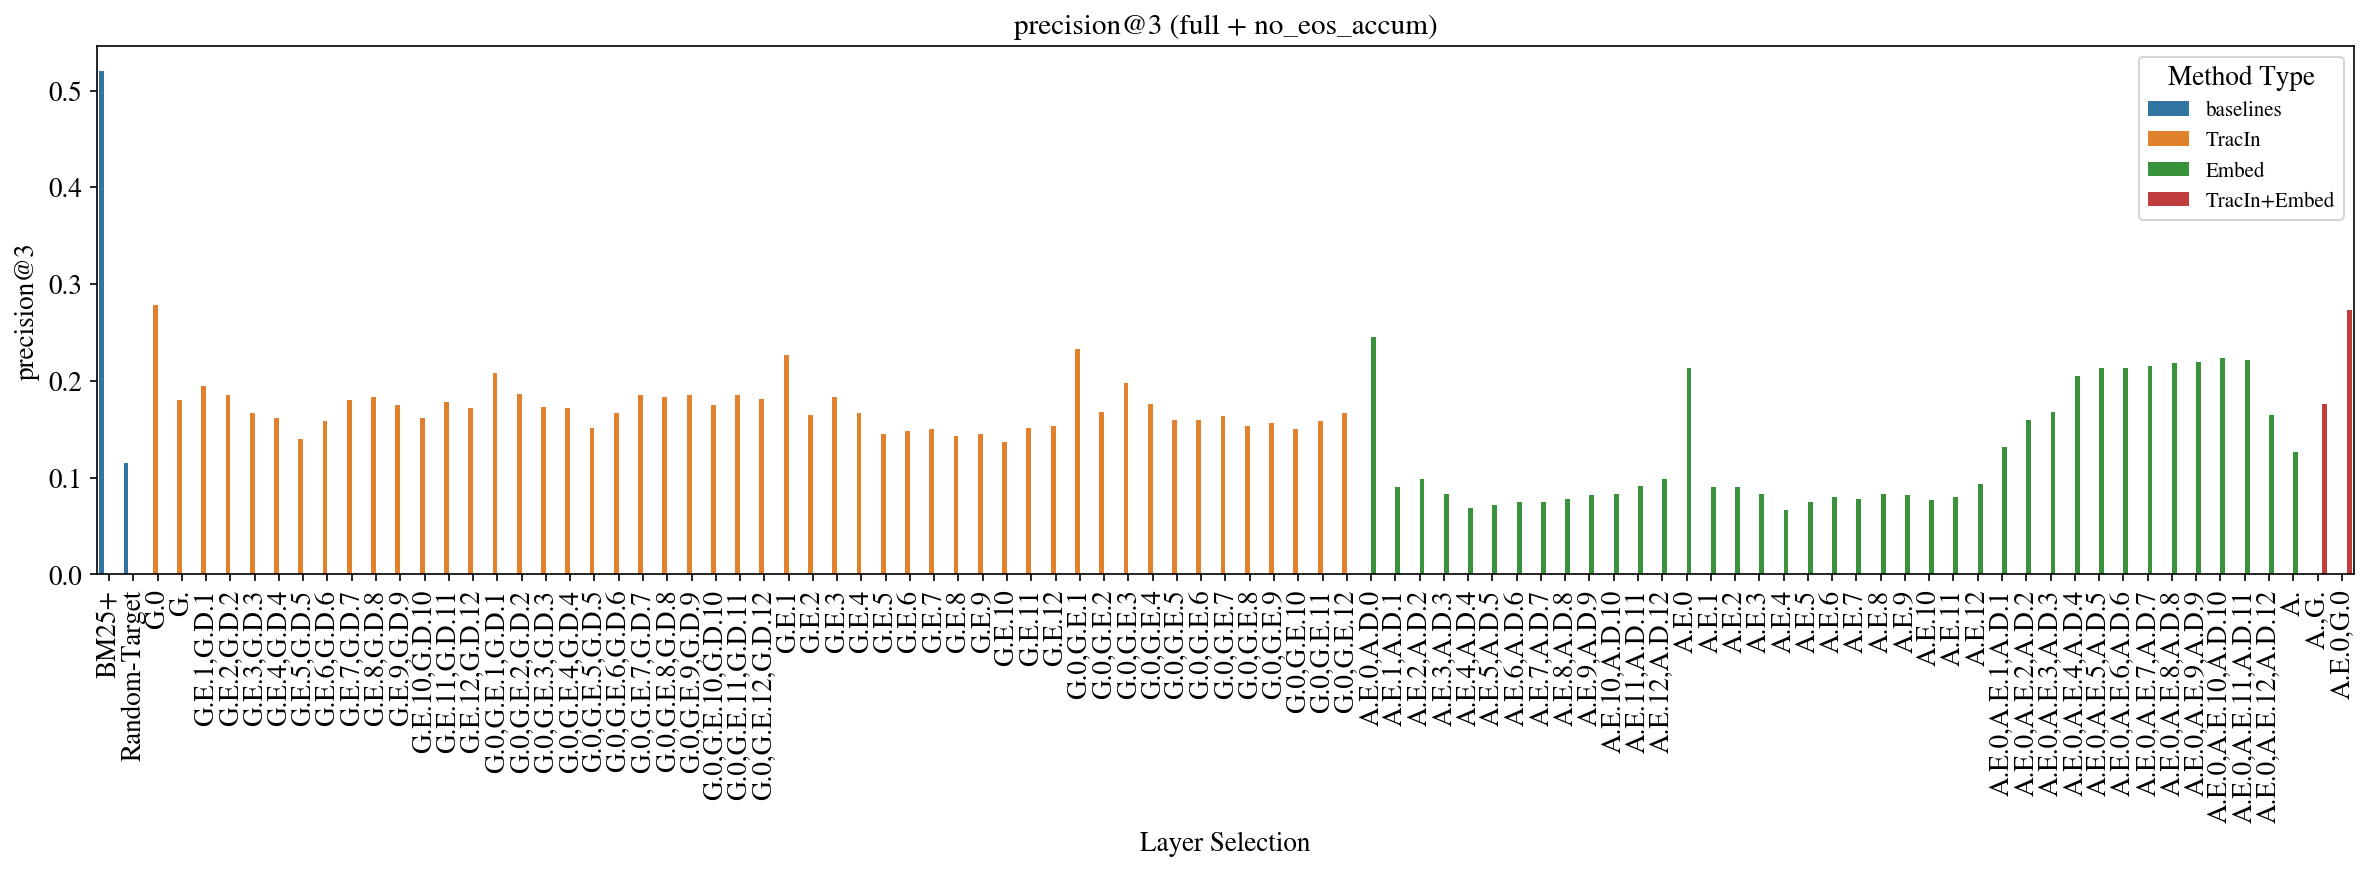

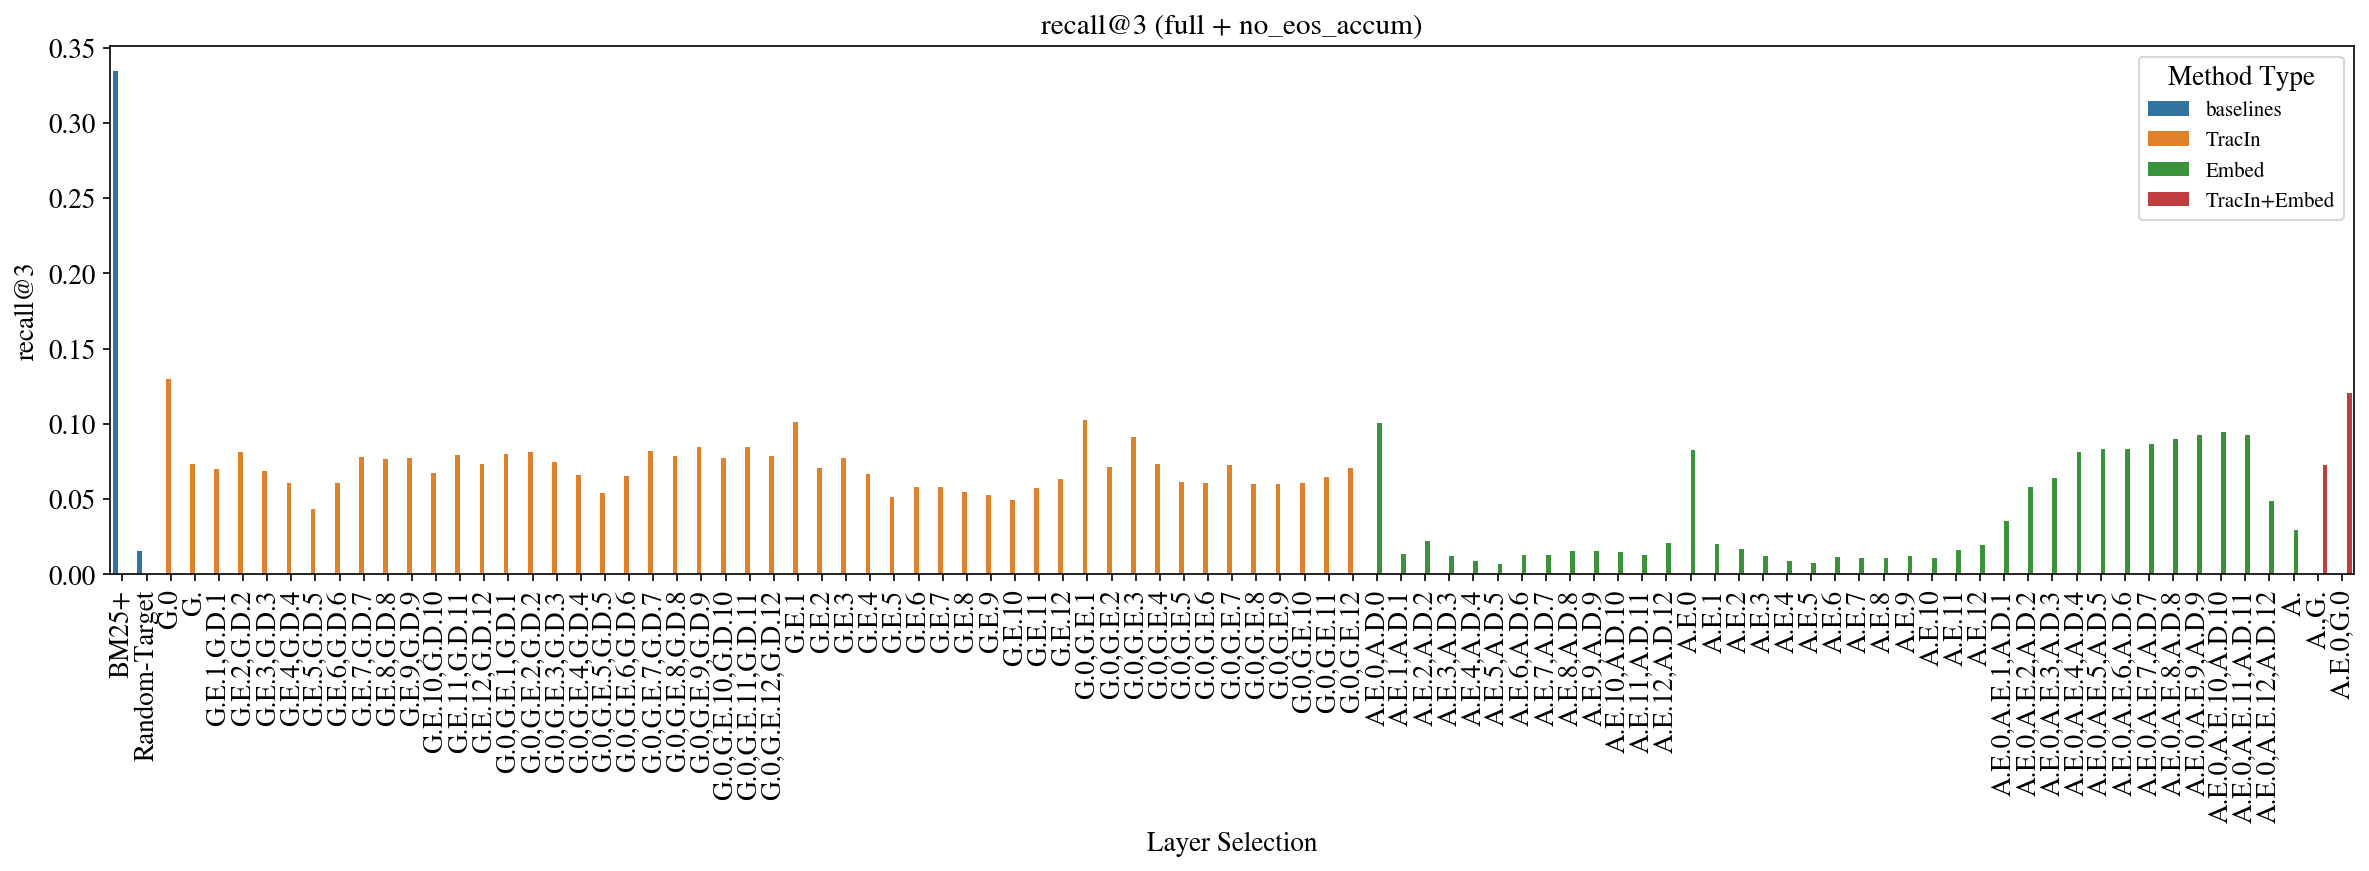

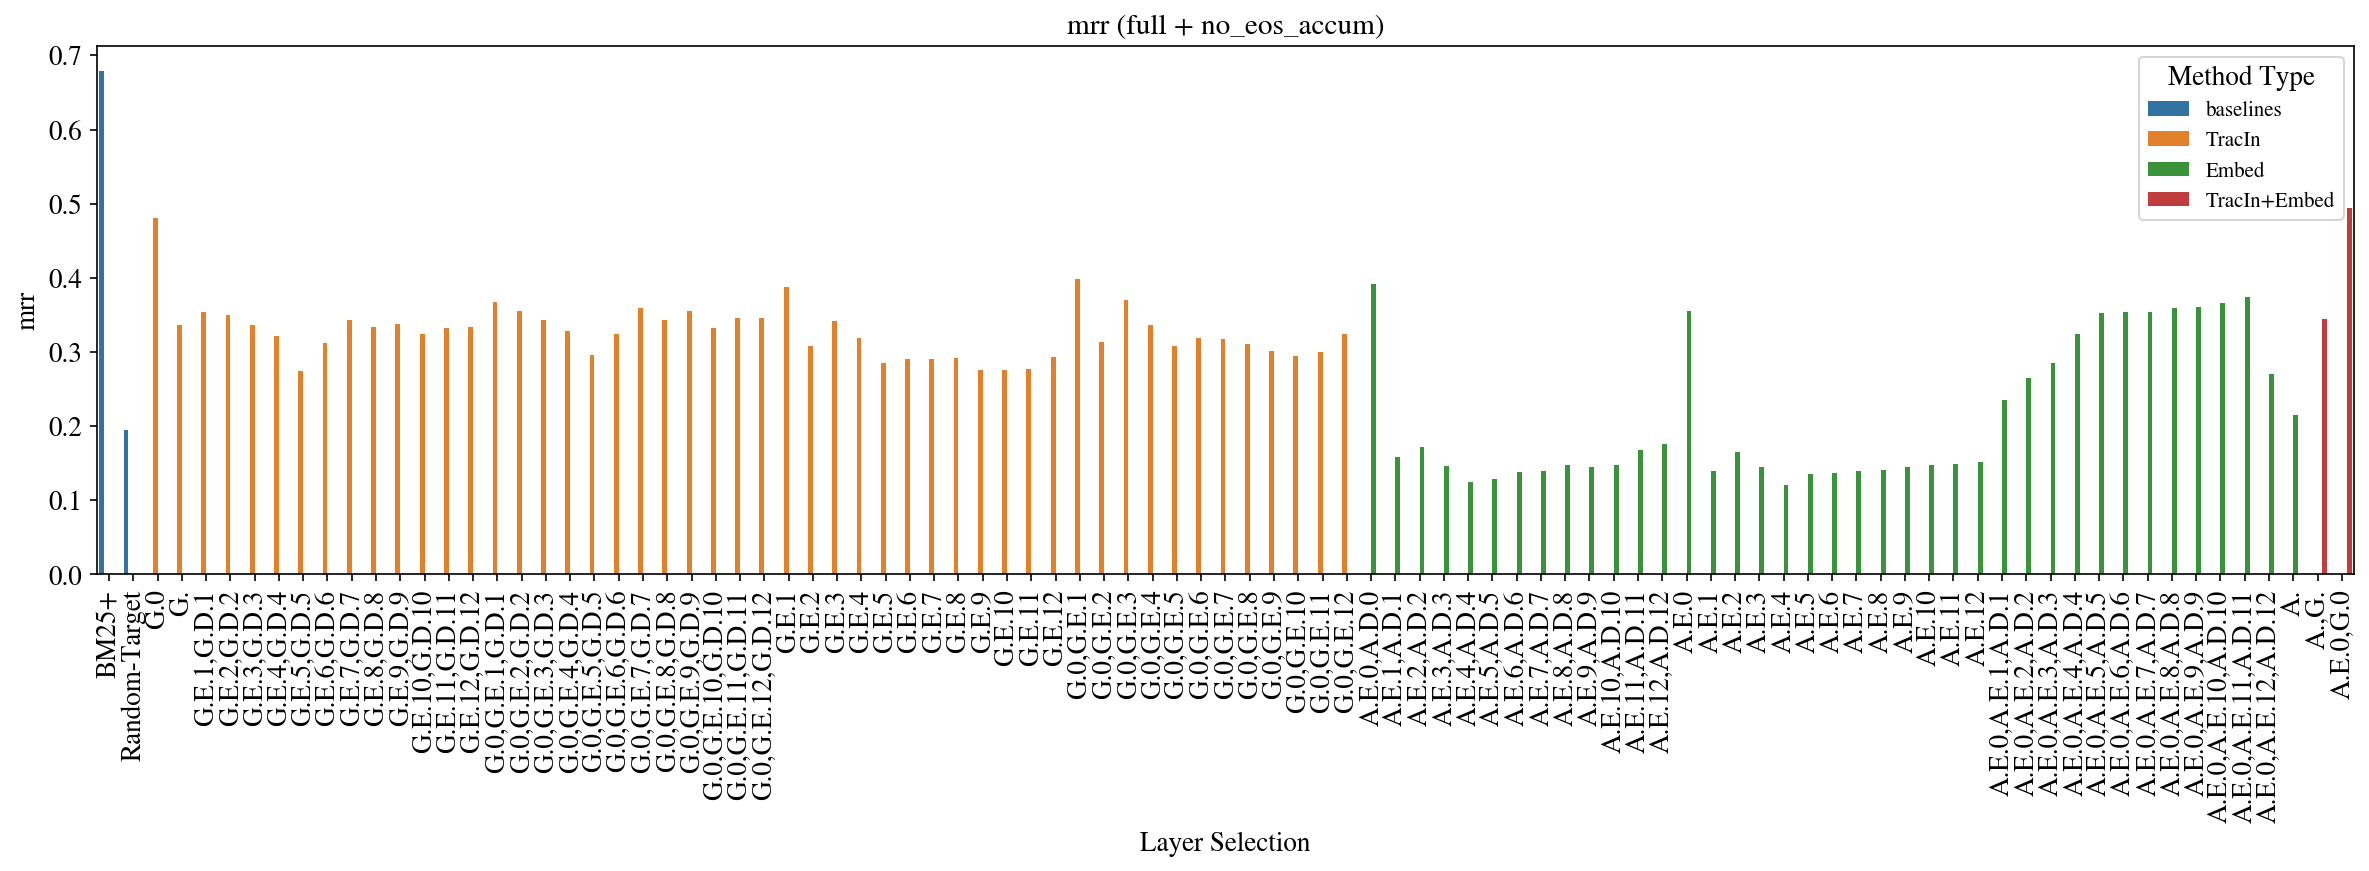

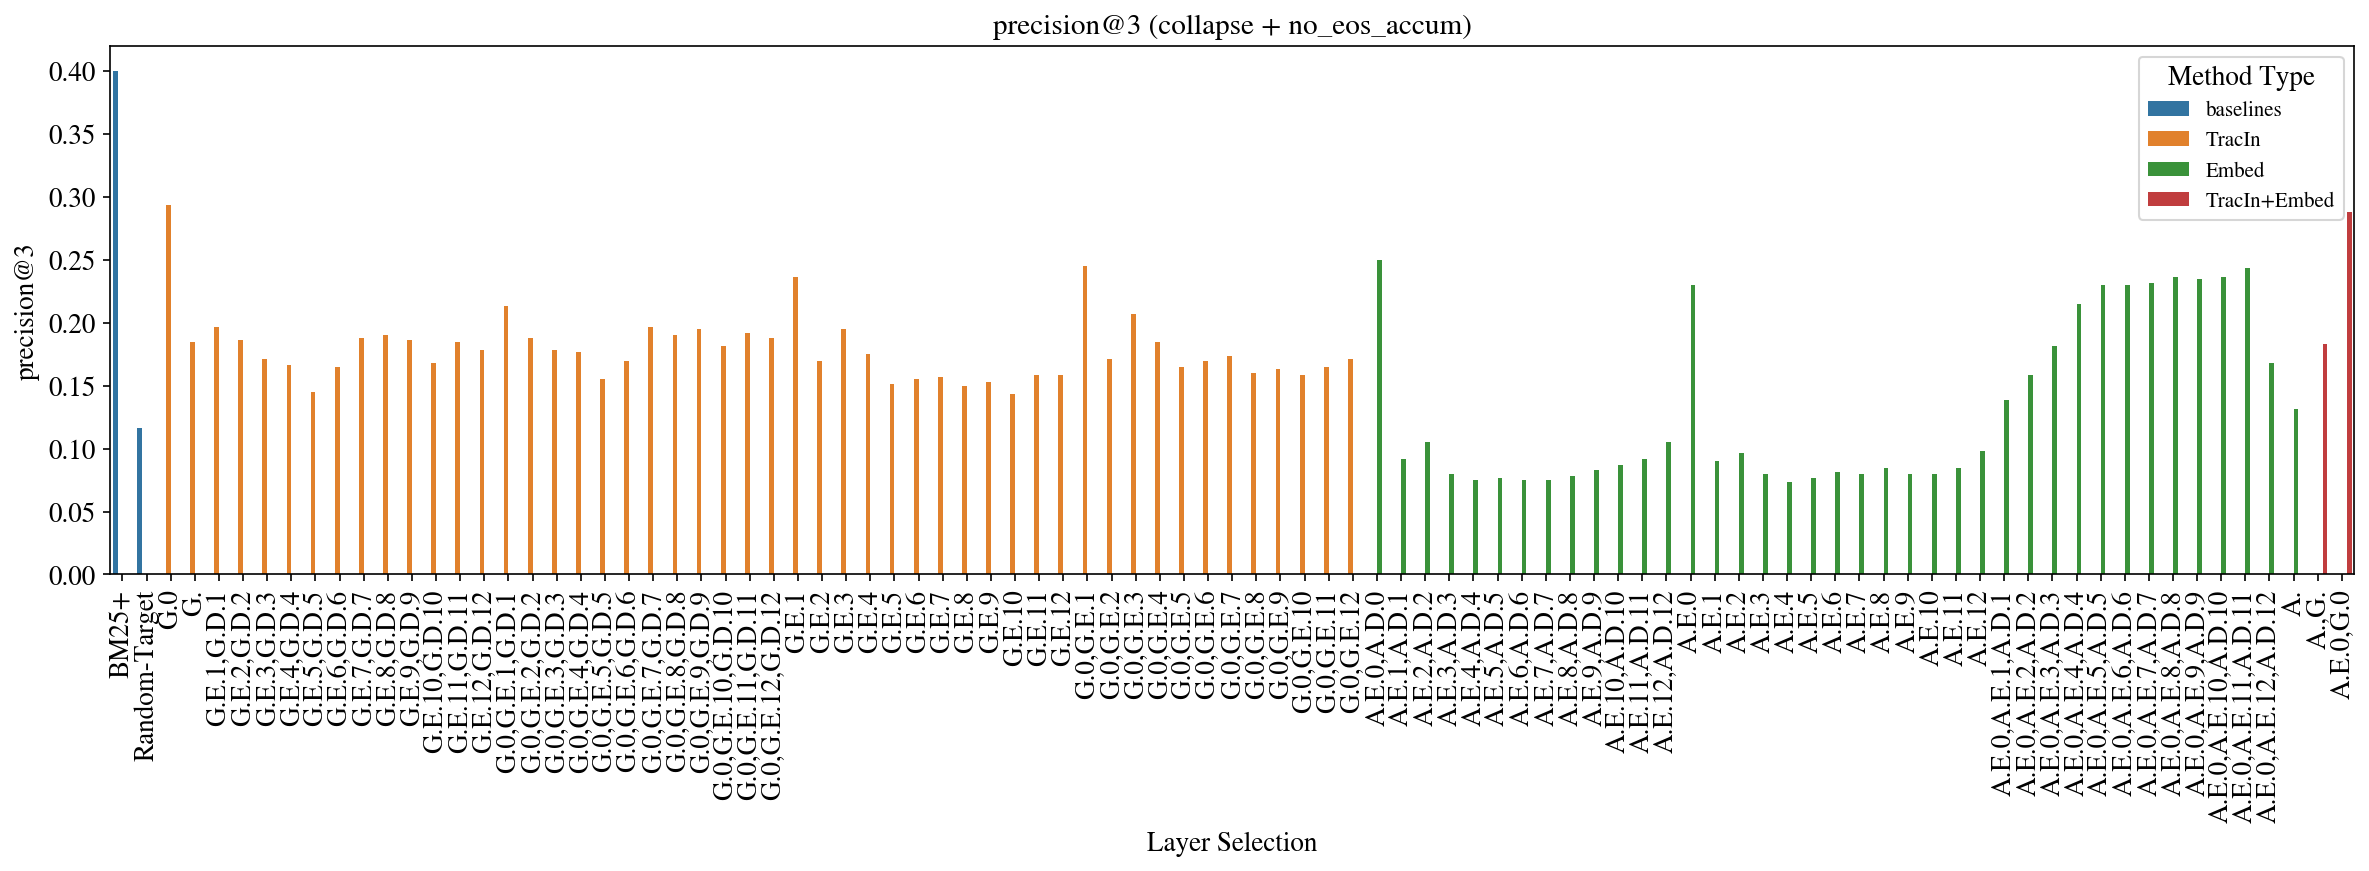

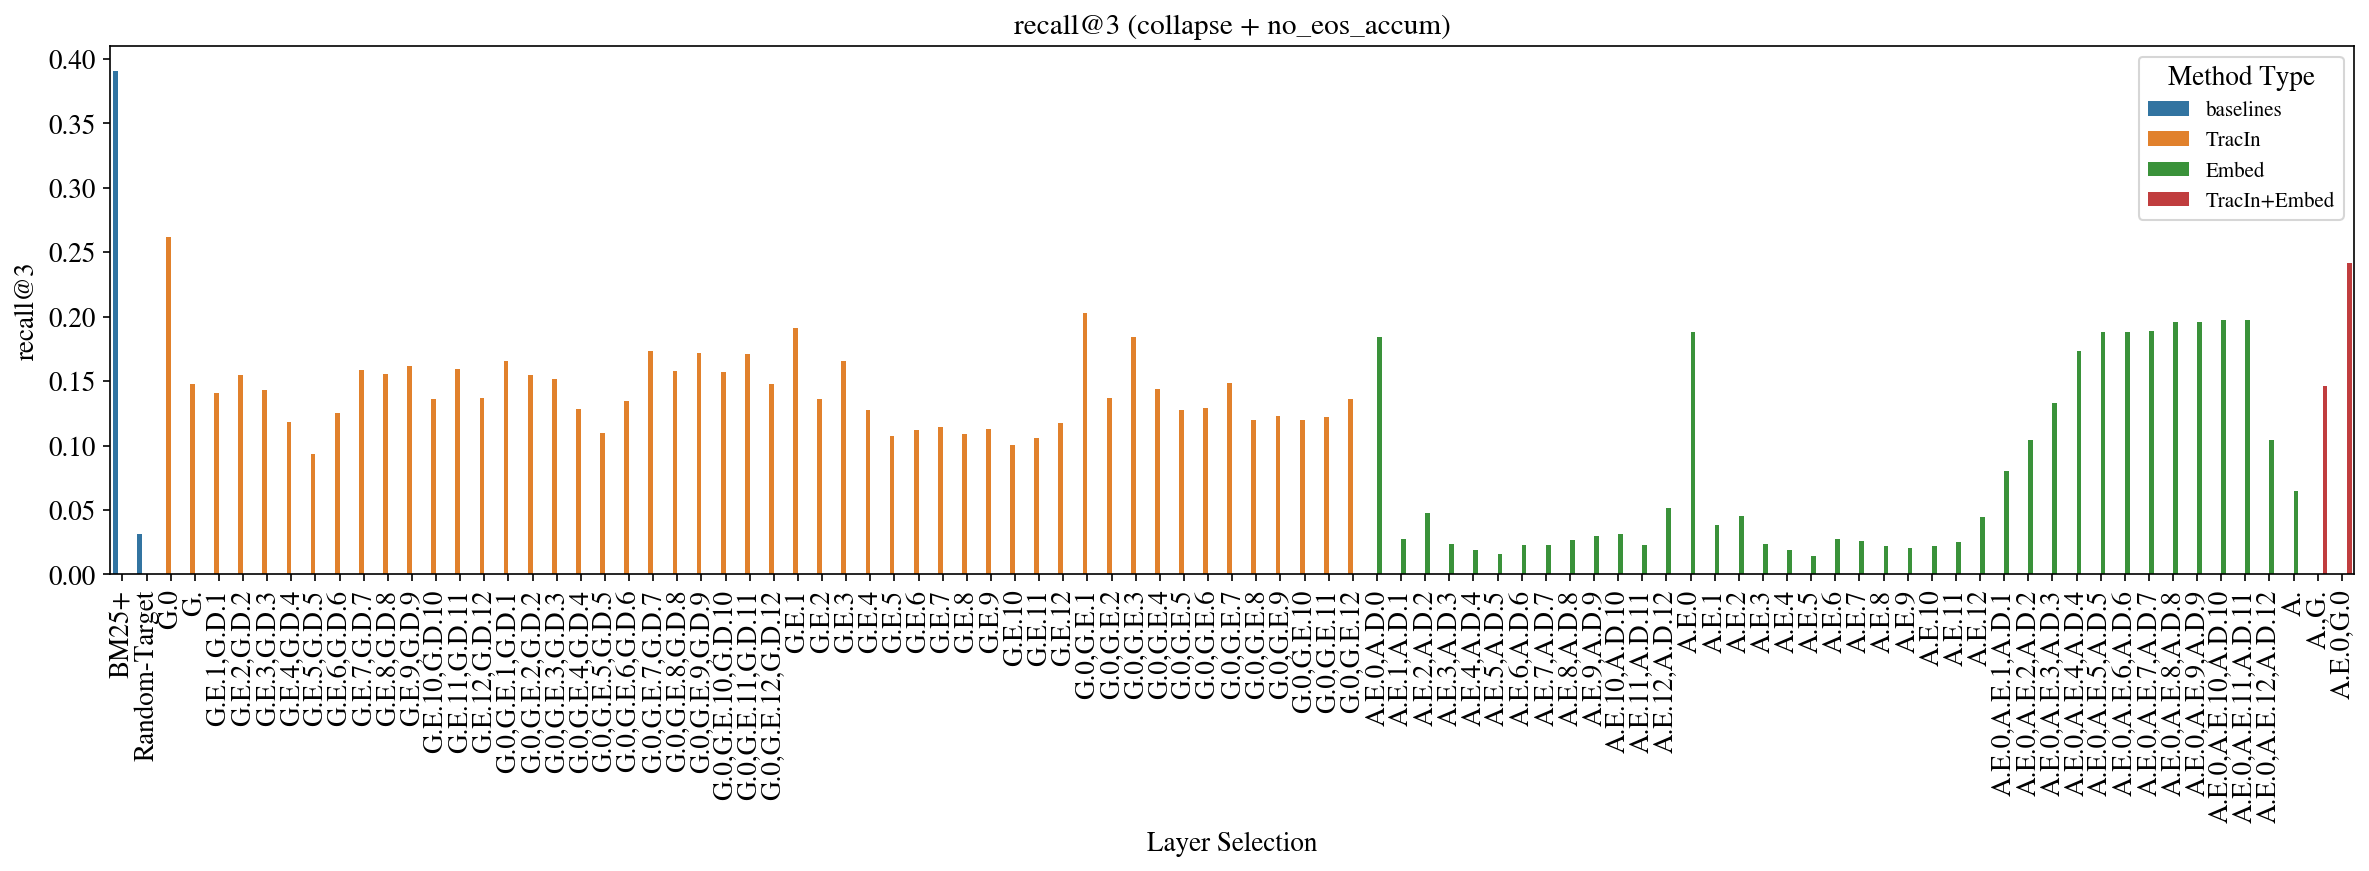

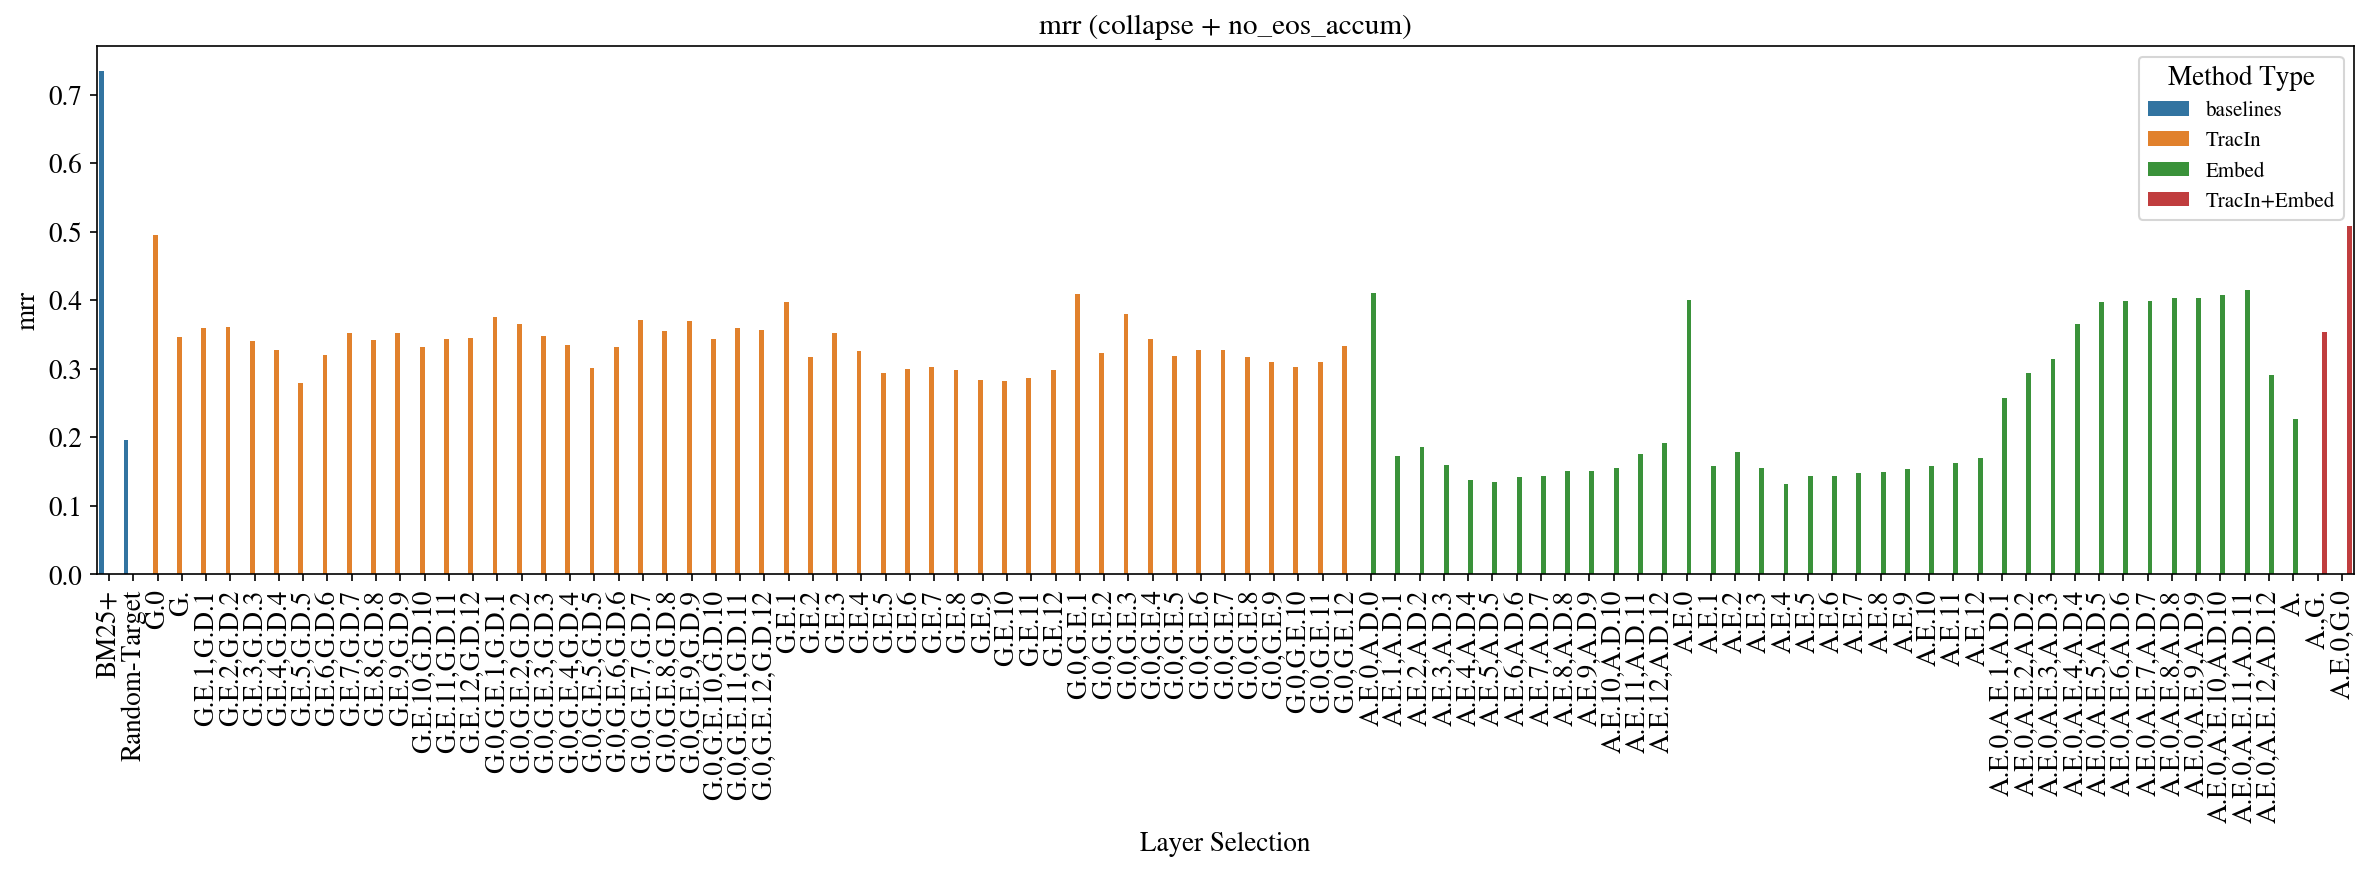

In [84]:
df  = visualize_one_experiment(paths=[f'reranker/unfiltered/seed_{i}/learned/no_eos_accum/results.pickle' for i in range(1)], 
                               suffix="no_eos_accum", 
                               save=False,
                               visualize=True)

In [93]:
dfs = {}
for eos in ("no_eos", ):
    for subset in ("learned", ):
        for accum in ("no_accum", "accum"):
            try:
                suffix=f"{eos}+{subset}+{accum}"
                dfs[suffix] = visualize_one_experiment(paths=[f'reranker/unfiltered/seed_{i}/{subset}/{eos}_{accum}/results.pickle'
                                                            for i in range(1)], 
                                                      suffix=suffix, 
                                                      save=False,
                                                      visualize=False)
            except FileNotFoundError:
                print(f'reranker/unfiltered/seed_0/{subset}/{eos}_{accum}/results.pickle')

reranker/unfiltered/seed_0/learned/no_eos_no_accum/results.pickle


In [94]:
for (k, v) in dfs.items():
    eos, subset, accum = k.split('+')
    v['eos'] = eos
    v['subset'] = subset
    v['accum'] = accum
    

In [95]:
dfmerged = pd.concat(dfs.values(), ignore_index=False)

In [96]:
dfmerged.head()

,layers,norm_type,normalization,eval,metrics,k,score,layer_type,seed,eos,subset,accum
0,BM25+,local,cosine,collapse,precision,1,0.685,baselines,0,no_eos,learned,accum
1,BM25+,local,cosine,collapse,precision,3,0.400,baselines,0,no_eos,learned,accum
2,BM25+,local,cosine,collapse,precision,5,0.313,baselines,0,no_eos,learned,accum
3,BM25+,local,cosine,collapse,precision,10,0.237,baselines,0,no_eos,learned,accum
4,BM25+,local,cosine,collapse,precision,25,0.150,baselines,0,no_eos,learned,accum


In [97]:
scores = dfmerged.groupby([column for column in dfmerged.columns if column != 'seed'])\
                 .agg({'score': ['mean', 'std']}, as_index=False)
scores = scores.reset_index()
    

In [98]:
scores.head()

layers norm_type normalization      eval    metrics   k     score  \
                                                                      
0  A.     global    cosine        collapse  mrr        1   0.135303   
1  A.     global    cosine        collapse  precision  1   0.075000   
2  A.     global    cosine        collapse  precision  10  0.071500   
3  A.     global    cosine        collapse  precision  25  0.066800   
4  A.     global    cosine        collapse  precision  3   0.073333   

  layer_type     eos   subset  accum     score      
                                          mean std  
0  Embed      no_eos  learned  accum  0.135303 NaN  
1  Embed      no_eos  learned  accum  0.075000 NaN  
2  Embed      no_eos  learned  accum  0.071500 NaN  
3  Embed      no_eos  learned  accum  0.066800 NaN  
4  Embed      no_eos  learned  accum  0.073333 NaN

In [101]:
def get_max(df: pd.DataFrame, 
            prefix, 
            no_prefix=None, 
            subset='learned', 
            metric='mrr', 
            eval_type='collapse', 
            k='1'):
    
    df2 = df[(df['layers'].str.startswith(prefix)) & 
             (df['subset'] == subset) &
             (df['metrics'] == metric) &
             (df['k'] == str(k)) &
             (df['eval'] == eval_type)]
    
    if no_prefix:
        df2 = df2[~df2['layers'].str.contains(no_prefix)]
        
    nlargest = df2.nlargest(20, ('score', 'mean'))
    
    largest = nlargest.iloc[0]    
    dflargest = df[(df['layers'] == largest['layers'][0]) &
                   (df['norm_type'] == largest['norm_type'][0]) &
                   (df['eos'] == largest['eos'][0]) &
                   (df['accum'] == largest['accum'][0]) &
                   (df['subset'] == subset) &
                   (df['eval'] == eval_type)]
    
    return nlargest, dflargest


In [102]:
largest, dflargest = get_max(scores, 'A', no_prefix='G')
display(largest)
display(dflargest)

layers norm_type normalization      eval metrics  k  \
                                                                               
462   A.E.0,A.D.0,A.E.12,A.D.12  global    cosine        collapse  mrr     1   
198   A.E.0,A.D.0                global    cosine        collapse  mrr     1   
1320  A.E.0,A.E.12,A.D.12        global    cosine        collapse  mrr     1   
1276  A.E.0,A.E.11,A.D.11        local     cosine        collapse  mrr     1   
220   A.E.0,A.D.0                local     cosine        collapse  mrr     1   
418   A.E.0,A.D.0,A.E.11,A.D.11  local     cosine        collapse  mrr     1   
352   A.E.0,A.D.0,A.E.10,A.D.10  local     cosine        collapse  mrr     1   
1210  A.E.0,A.E.10,A.D.10        local     cosine        collapse  mrr     1   
946   A.E.0,A.D.0,A.E.8,A.D.8    local     cosine        collapse  mrr     1   
1012  A.E.0,A.D.0,A.E.9,A.D.9    local     cosine        collapse  mrr     1   
814   A.E.0,A.D.0,A.E.6,A.D.6    local     cosine        collapse  mrr     1   
880   A.E.0,A.D.0,A.E.7,A.D.7    local     cosine        collapse  mrr     1   
748   A.E.0,A.D.0,A.E.5,A.D.5    local     cosine        collapse  mrr     1   
1870  A.E.0,A.E.9,A.D.9          local     cosine        collapse  mrr     1   
1804  A.E.0,A.E.8,A.D.8          local     cosine        collapse  mrr     1   
132   A.E.0                      global    cosine        collapse  mrr     1   
154   A.E.0                      local     cosine        collapse  mrr     1   
1738  A.E.0,A.E.7,A.D.7          local     cosine        collapse  mrr     1   
1672  A.E.0,A.E.6,A.D.6          local     cosine        collapse  mrr     1   
1606  A.E.0,A.E.5,A.D.5          local     cosine        collapse  mrr     1   

         score layer_type     eos   subset  accum     score      
                                                       mean std  
462   0.483215  Embed      no_eos  learned  accum  0.483215 NaN  
198   0.482083  Embed      no_eos  learned  accum  0.482083 NaN  
1320  0.438417  Embed      no_eos  learned  accum  0.438417 NaN  
1276  0.414970  Embed      no_eos  learned  accum  0.414970 NaN  
220   0.410640  Embed      no_eos  learned  accum  0.410640 NaN  
418   0.409535  Embed      no_eos  learned  accum  0.409535 NaN  
352   0.408346  Embed      no_eos  learned  accum  0.408346 NaN  
1210  0.408168  Embed      no_eos  learned  accum  0.408168 NaN  
946   0.408124  Embed      no_eos  learned  accum  0.408124 NaN  
1012  0.407944  Embed      no_eos  learned  accum  0.407944 NaN  
814   0.407706  Embed      no_eos  learned  accum  0.407706 NaN  
880   0.407706  Embed      no_eos  learned  accum  0.407706 NaN  
748   0.407539  Embed      no_eos  learned  accum  0.407539 NaN  
1870  0.403654  Embed      no_eos  learned  accum  0.403654 NaN  
1804  0.402755  Embed      no_eos  learned  accum  0.402755 NaN  
132   0.399869  Embed      no_eos  learned  accum  0.399869 NaN  
154   0.399869  Embed      no_eos  learned  accum  0.399869 NaN  
1738  0.398298  Embed      no_eos  learned  accum  0.398298 NaN  
1672  0.398225  Embed      no_eos  learned  accum  0.398225 NaN  
1606  0.398054  Embed      no_eos  learned  accum  0.398054 NaN

layers norm_type normalization      eval    metrics  \
                                                                              
462  A.E.0,A.D.0,A.E.12,A.D.12  global    cosine        collapse  mrr         
463  A.E.0,A.D.0,A.E.12,A.D.12  global    cosine        collapse  precision   
464  A.E.0,A.D.0,A.E.12,A.D.12  global    cosine        collapse  precision   
465  A.E.0,A.D.0,A.E.12,A.D.12  global    cosine        collapse  precision   
466  A.E.0,A.D.0,A.E.12,A.D.12  global    cosine        collapse  precision   
467  A.E.0,A.D.0,A.E.12,A.D.12  global    cosine        collapse  precision   
468  A.E.0,A.D.0,A.E.12,A.D.12  global    cosine        collapse  recall      
469  A.E.0,A.D.0,A.E.12,A.D.12  global    cosine        collapse  recall      
470  A.E.0,A.D.0,A.E.12,A.D.12  global    cosine        collapse  recall      
471  A.E.0,A.D.0,A.E.12,A.D.12  global    cosine        collapse  recall      
472  A.E.0,A.D.0,A.E.12,A.D.12  global    cosine        collapse  recall      

      k     score layer_type     eos   subset  accum     score      
                                                          mean std  
462  1   0.483215  Embed      no_eos  learned  accum  0.483215 NaN  
463  1   0.380000  Embed      no_eos  learned  accum  0.380000 NaN  
464  10  0.200000  Embed      no_eos  learned  accum  0.200000 NaN  
465  25  0.155400  Embed      no_eos  learned  accum  0.155400 NaN  
466  3   0.281667  Embed      no_eos  learned  accum  0.281667 NaN  
467  5   0.250000  Embed      no_eos  learned  accum  0.250000 NaN  
468  1   0.126863  Embed      no_eos  learned  accum  0.126863 NaN  
469  10  0.334180  Embed      no_eos  learned  accum  0.334180 NaN  
470  25  0.496075  Embed      no_eos  learned  accum  0.496075 NaN  
471  3   0.208005  Embed      no_eos  learned  accum  0.208005 NaN  
472  5   0.257863  Embed      no_eos  learned  accum  0.257863 NaN

In [103]:
largest, dflargest = get_max(scores, 'A')
display(largest)
display(dflargest)

layers norm_type normalization      eval metrics  k  \
                                                                               
1056  A.E.0,A.D.0,G.0            global    cosine        collapse  mrr     1   
1914  A.E.0,G.0                  global    cosine        collapse  mrr     1   
1936  A.E.0,G.0                  local     cosine        collapse  mrr     1   
1078  A.E.0,A.D.0,G.0            local     cosine        collapse  mrr     1   
462   A.E.0,A.D.0,A.E.12,A.D.12  global    cosine        collapse  mrr     1   
198   A.E.0,A.D.0                global    cosine        collapse  mrr     1   
1320  A.E.0,A.E.12,A.D.12        global    cosine        collapse  mrr     1   
1276  A.E.0,A.E.11,A.D.11        local     cosine        collapse  mrr     1   
220   A.E.0,A.D.0                local     cosine        collapse  mrr     1   
418   A.E.0,A.D.0,A.E.11,A.D.11  local     cosine        collapse  mrr     1   
352   A.E.0,A.D.0,A.E.10,A.D.10  local     cosine        collapse  mrr     1   
1210  A.E.0,A.E.10,A.D.10        local     cosine        collapse  mrr     1   
946   A.E.0,A.D.0,A.E.8,A.D.8    local     cosine        collapse  mrr     1   
1012  A.E.0,A.D.0,A.E.9,A.D.9    local     cosine        collapse  mrr     1   
814   A.E.0,A.D.0,A.E.6,A.D.6    local     cosine        collapse  mrr     1   
880   A.E.0,A.D.0,A.E.7,A.D.7    local     cosine        collapse  mrr     1   
748   A.E.0,A.D.0,A.E.5,A.D.5    local     cosine        collapse  mrr     1   
1870  A.E.0,A.E.9,A.D.9          local     cosine        collapse  mrr     1   
1804  A.E.0,A.E.8,A.D.8          local     cosine        collapse  mrr     1   
132   A.E.0                      global    cosine        collapse  mrr     1   

         score    layer_type     eos   subset  accum     score      
                                                          mean std  
1056  0.522643  TracIn+Embed  no_eos  learned  accum  0.522643 NaN  
1914  0.509002  TracIn+Embed  no_eos  learned  accum  0.509002 NaN  
1936  0.509002  TracIn+Embed  no_eos  learned  accum  0.509002 NaN  
1078  0.503848  TracIn+Embed  no_eos  learned  accum  0.503848 NaN  
462   0.483215  Embed         no_eos  learned  accum  0.483215 NaN  
198   0.482083  Embed         no_eos  learned  accum  0.482083 NaN  
1320  0.438417  Embed         no_eos  learned  accum  0.438417 NaN  
1276  0.414970  Embed         no_eos  learned  accum  0.414970 NaN  
220   0.410640  Embed         no_eos  learned  accum  0.410640 NaN  
418   0.409535  Embed         no_eos  learned  accum  0.409535 NaN  
352   0.408346  Embed         no_eos  learned  accum  0.408346 NaN  
1210  0.408168  Embed         no_eos  learned  accum  0.408168 NaN  
946   0.408124  Embed         no_eos  learned  accum  0.408124 NaN  
1012  0.407944  Embed         no_eos  learned  accum  0.407944 NaN  
814   0.407706  Embed         no_eos  learned  accum  0.407706 NaN  
880   0.407706  Embed         no_eos  learned  accum  0.407706 NaN  
748   0.407539  Embed         no_eos  learned  accum  0.407539 NaN  
1870  0.403654  Embed         no_eos  learned  accum  0.403654 NaN  
1804  0.402755  Embed         no_eos  learned  accum  0.402755 NaN  
132   0.399869  Embed         no_eos  learned  accum  0.399869 NaN

layers norm_type normalization      eval    metrics   k  \
                                                                         
1056  A.E.0,A.D.0,G.0  global    cosine        collapse  mrr        1    
1057  A.E.0,A.D.0,G.0  global    cosine        collapse  precision  1    
1058  A.E.0,A.D.0,G.0  global    cosine        collapse  precision  10   
1059  A.E.0,A.D.0,G.0  global    cosine        collapse  precision  25   
1060  A.E.0,A.D.0,G.0  global    cosine        collapse  precision  3    
1061  A.E.0,A.D.0,G.0  global    cosine        collapse  precision  5    
1062  A.E.0,A.D.0,G.0  global    cosine        collapse  recall     1    
1063  A.E.0,A.D.0,G.0  global    cosine        collapse  recall     10   
1064  A.E.0,A.D.0,G.0  global    cosine        collapse  recall     25   
1065  A.E.0,A.D.0,G.0  global    cosine        collapse  recall     3    
1066  A.E.0,A.D.0,G.0  global    cosine        collapse  recall     5    

         score    layer_type     eos   subset  accum     score      
                                                          mean std  
1056  0.522643  TracIn+Embed  no_eos  learned  accum  0.522643 NaN  
1057  0.430000  TracIn+Embed  no_eos  learned  accum  0.430000 NaN  
1058  0.203000  TracIn+Embed  no_eos  learned  accum  0.203000 NaN  
1059  0.159200  TracIn+Embed  no_eos  learned  accum  0.159200 NaN  
1060  0.305000  TracIn+Embed  no_eos  learned  accum  0.305000 NaN  
1061  0.253000  TracIn+Embed  no_eos  learned  accum  0.253000 NaN  
1062  0.166481  TracIn+Embed  no_eos  learned  accum  0.166481 NaN  
1063  0.386249  TracIn+Embed  no_eos  learned  accum  0.386249 NaN  
1064  0.541048  TracIn+Embed  no_eos  learned  accum  0.541048 NaN  
1065  0.268070  TracIn+Embed  no_eos  learned  accum  0.268070 NaN  
1066  0.307374  TracIn+Embed  no_eos  learned  accum  0.307374 NaN

In [104]:
largest, dflargest = get_max(scores, 'G')
display(largest)
display(dflargest)

layers norm_type normalization      eval metrics  k  \
                                                                       
3718  G.0                global    cosine        collapse  mrr     1   
3740  G.0                local     cosine        collapse  mrr     1   
3806  G.0,G.E.1          local     cosine        collapse  mrr     1   
3784  G.0,G.E.1          global    cosine        collapse  mrr     1   
5368  G.E.1              global    cosine        collapse  mrr     1   
5390  G.E.1              local     cosine        collapse  mrr     1   
4510  G.0,G.E.3,G.D.3    global    cosine        collapse  mrr     1   
4466  G.0,G.E.3          local     cosine        collapse  mrr     1   
3872  G.0,G.E.1,G.D.1    local     cosine        collapse  mrr     1   
6094  G.E.3,G.D.3        global    cosine        collapse  mrr     1   
5060  G.0,G.E.7,G.D.7    local     cosine        collapse  mrr     1   
4114  G.0,G.E.11,G.D.11  global    cosine        collapse  mrr     1   
5324  G.0,G.E.9,G.D.9    local     cosine        collapse  mrr     1   
4400  G.0,G.E.2,G.D.2    local     cosine        collapse  mrr     1   
5698  G.E.11,G.D.11      global    cosine        collapse  mrr     1   
5984  G.E.2,G.D.2        local     cosine        collapse  mrr     1   
5456  G.E.1,G.D.1        local     cosine        collapse  mrr     1   
4136  G.0,G.E.11,G.D.11  local     cosine        collapse  mrr     1   
4268  G.0,G.E.12,G.D.12  local     cosine        collapse  mrr     1   
5192  G.0,G.E.8,G.D.8    local     cosine        collapse  mrr     1   

         score layer_type     eos   subset  accum     score      
                                                       mean std  
3718  0.495679  TracIn     no_eos  learned  accum  0.495679 NaN  
3740  0.495679  TracIn     no_eos  learned  accum  0.495679 NaN  
3806  0.408880  TracIn     no_eos  learned  accum  0.408880 NaN  
3784  0.405805  TracIn     no_eos  learned  accum  0.405805 NaN  
5368  0.397481  TracIn     no_eos  learned  accum  0.397481 NaN  
5390  0.397024  TracIn     no_eos  learned  accum  0.397024 NaN  
4510  0.380770  TracIn     no_eos  learned  accum  0.380770 NaN  
4466  0.379771  TracIn     no_eos  learned  accum  0.379771 NaN  
3872  0.375809  TracIn     no_eos  learned  accum  0.375809 NaN  
6094  0.374713  TracIn     no_eos  learned  accum  0.374713 NaN  
5060  0.371436  TracIn     no_eos  learned  accum  0.371436 NaN  
4114  0.371338  TracIn     no_eos  learned  accum  0.371338 NaN  
5324  0.369039  TracIn     no_eos  learned  accum  0.369039 NaN  
4400  0.365802  TracIn     no_eos  learned  accum  0.365802 NaN  
5698  0.365578  TracIn     no_eos  learned  accum  0.365578 NaN  
5984  0.361023  TracIn     no_eos  learned  accum  0.361023 NaN  
5456  0.360186  TracIn     no_eos  learned  accum  0.360186 NaN  
4136  0.359189  TracIn     no_eos  learned  accum  0.359189 NaN  
4268  0.356478  TracIn     no_eos  learned  accum  0.356478 NaN  
5192  0.355302  TracIn     no_eos  learned  accum  0.355302 NaN

layers norm_type normalization      eval    metrics   k     score  \
                                                                         
3718  G.0    global    cosine        collapse  mrr        1   0.495679   
3719  G.0    global    cosine        collapse  precision  1   0.400000   
3720  G.0    global    cosine        collapse  precision  10  0.192000   
3721  G.0    global    cosine        collapse  precision  25  0.145200   
3722  G.0    global    cosine        collapse  precision  3   0.293333   
3723  G.0    global    cosine        collapse  precision  5   0.242000   
3724  G.0    global    cosine        collapse  recall     1   0.161981   
3725  G.0    global    cosine        collapse  recall     10  0.359431   
3726  G.0    global    cosine        collapse  recall     25  0.476332   
3727  G.0    global    cosine        collapse  recall     3   0.261617   
3728  G.0    global    cosine        collapse  recall     5   0.307707   

     layer_type     eos   subset  accum     score      
                                             mean std  
3718  TracIn     no_eos  learned  accum  0.495679 NaN  
3719  TracIn     no_eos  learned  accum  0.400000 NaN  
3720  TracIn     no_eos  learned  accum  0.192000 NaN  
3721  TracIn     no_eos  learned  accum  0.145200 NaN  
3722  TracIn     no_eos  learned  accum  0.293333 NaN  
3723  TracIn     no_eos  learned  accum  0.242000 NaN  
3724  TracIn     no_eos  learned  accum  0.161981 NaN  
3725  TracIn     no_eos  learned  accum  0.359431 NaN  
3726  TracIn     no_eos  learned  accum  0.476332 NaN  
3727  TracIn     no_eos  learned  accum  0.261617 NaN  
3728  TracIn     no_eos  learned  accum  0.307707 NaN

In [105]:
largest, dflargest = get_max(scores, 'BM25+')
display(largest)
display(dflargest)

layers norm_type normalization      eval metrics  k     score layer_type  \
                                                                                
3564  BM25+  global    cosine        collapse  mrr     1  0.734004  baselines   
3586  BM25+  global    dot           collapse  mrr     1  0.734004  baselines   
3608  BM25+  local     cosine        collapse  mrr     1  0.734004  baselines   
3630  BM25+  local     dot           collapse  mrr     1  0.734004  baselines   

         eos   subset  accum     score      
                                  mean std  
3564  no_eos  learned  accum  0.734004 NaN  
3586  no_eos  learned  accum  0.734004 NaN  
3608  no_eos  learned  accum  0.734004 NaN  
3630  no_eos  learned  accum  0.734004 NaN

layers norm_type normalization      eval    metrics   k     score  \
                                                                         
3564  BM25+  global    cosine        collapse  mrr        1   0.734004   
3565  BM25+  global    cosine        collapse  precision  1   0.685000   
3566  BM25+  global    cosine        collapse  precision  10  0.237000   
3567  BM25+  global    cosine        collapse  precision  25  0.150000   
3568  BM25+  global    cosine        collapse  precision  3   0.400000   
3569  BM25+  global    cosine        collapse  precision  5   0.313000   
3570  BM25+  global    cosine        collapse  recall     1   0.308602   
3571  BM25+  global    cosine        collapse  recall     10  0.494997   
3572  BM25+  global    cosine        collapse  recall     25  0.579171   
3573  BM25+  global    cosine        collapse  recall     3   0.390497   
3574  BM25+  global    cosine        collapse  recall     5   0.426078   
3586  BM25+  global    dot           collapse  mrr        1   0.734004   
3587  BM25+  global    dot           collapse  precision  1   0.685000   
3588  BM25+  global    dot           collapse  precision  10  0.237000   
3589  BM25+  global    dot           collapse  precision  25  0.150000   
3590  BM25+  global    dot           collapse  precision  3   0.400000   
3591  BM25+  global    dot           collapse  precision  5   0.313000   
3592  BM25+  global    dot           collapse  recall     1   0.308602   
3593  BM25+  global    dot           collapse  recall     10  0.494997   
3594  BM25+  global    dot           collapse  recall     25  0.579171   
3595  BM25+  global    dot           collapse  recall     3   0.390497   
3596  BM25+  global    dot           collapse  recall     5   0.426078   

     layer_type     eos   subset  accum     score      
                                             mean std  
3564  baselines  no_eos  learned  accum  0.734004 NaN  
3565  baselines  no_eos  learned  accum  0.685000 NaN  
3566  baselines  no_eos  learned  accum  0.237000 NaN  
3567  baselines  no_eos  learned  accum  0.150000 NaN  
3568  baselines  no_eos  learned  accum  0.400000 NaN  
3569  baselines  no_eos  learned  accum  0.313000 NaN  
3570  baselines  no_eos  learned  accum  0.308602 NaN  
3571  baselines  no_eos  learned  accum  0.494997 NaN  
3572  baselines  no_eos  learned  accum  0.579171 NaN  
3573  baselines  no_eos  learned  accum  0.390497 NaN  
3574  baselines  no_eos  learned  accum  0.426078 NaN  
3586  baselines  no_eos  learned  accum  0.734004 NaN  
3587  baselines  no_eos  learned  accum  0.685000 NaN  
3588  baselines  no_eos  learned  accum  0.237000 NaN  
3589  baselines  no_eos  learned  accum  0.150000 NaN  
3590  baselines  no_eos  learned  accum  0.400000 NaN  
3591  baselines  no_eos  learned  accum  0.313000 NaN  
3592  baselines  no_eos  learned  accum  0.308602 NaN  
3593  baselines  no_eos  learned  accum  0.494997 NaN  
3594  baselines  no_eos  learned  accum  0.579171 NaN  
3595  baselines  no_eos  learned  accum  0.390497 NaN  
3596  baselines  no_eos  learned  accum  0.426078 NaN

In [106]:
largest, dflargest  = get_max(scores, 'Random-Target')
display(largest)
display(dflargest)

layers norm_type normalization      eval metrics  k     score  \
                                                                             
6952  Random-Target  global    cosine        collapse  mrr     1  0.196824   
6974  Random-Target  global    dot           collapse  mrr     1  0.196824   
6996  Random-Target  local     cosine        collapse  mrr     1  0.196824   
7018  Random-Target  local     dot           collapse  mrr     1  0.196824   

     layer_type     eos   subset  accum     score      
                                             mean std  
6952  baselines  no_eos  learned  accum  0.196824 NaN  
6974  baselines  no_eos  learned  accum  0.196824 NaN  
6996  baselines  no_eos  learned  accum  0.196824 NaN  
7018  baselines  no_eos  learned  accum  0.196824 NaN

layers norm_type normalization      eval    metrics   k  \
                                                                       
6952  Random-Target  global    cosine        collapse  mrr        1    
6953  Random-Target  global    cosine        collapse  precision  1    
6954  Random-Target  global    cosine        collapse  precision  10   
6955  Random-Target  global    cosine        collapse  precision  25   
6956  Random-Target  global    cosine        collapse  precision  3    
6957  Random-Target  global    cosine        collapse  precision  5    
6958  Random-Target  global    cosine        collapse  recall     1    
6959  Random-Target  global    cosine        collapse  recall     10   
6960  Random-Target  global    cosine        collapse  recall     25   
6961  Random-Target  global    cosine        collapse  recall     3    
6962  Random-Target  global    cosine        collapse  recall     5    
6974  Random-Target  global    dot           collapse  mrr        1    
6975  Random-Target  global    dot           collapse  precision  1    
6976  Random-Target  global    dot           collapse  precision  10   
6977  Random-Target  global    dot           collapse  precision  25   
6978  Random-Target  global    dot           collapse  precision  3    
6979  Random-Target  global    dot           collapse  precision  5    
6980  Random-Target  global    dot           collapse  recall     1    
6981  Random-Target  global    dot           collapse  recall     10   
6982  Random-Target  global    dot           collapse  recall     25   
6983  Random-Target  global    dot           collapse  recall     3    
6984  Random-Target  global    dot           collapse  recall     5    

         score layer_type     eos   subset  accum     score      
                                                       mean std  
6952  0.196824  baselines  no_eos  learned  accum  0.196824 NaN  
6953  0.120000  baselines  no_eos  learned  accum  0.120000 NaN  
6954  0.096500  baselines  no_eos  learned  accum  0.096500 NaN  
6955  0.096000  baselines  no_eos  learned  accum  0.096000 NaN  
6956  0.116667  baselines  no_eos  learned  accum  0.116667 NaN  
6957  0.111000  baselines  no_eos  learned  accum  0.111000 NaN  
6958  0.013657  baselines  no_eos  learned  accum  0.013657 NaN  
6959  0.069997  baselines  no_eos  learned  accum  0.069997 NaN  
6960  0.198426  baselines  no_eos  learned  accum  0.198426 NaN  
6961  0.031641  baselines  no_eos  learned  accum  0.031641 NaN  
6962  0.045547  baselines  no_eos  learned  accum  0.045547 NaN  
6974  0.196824  baselines  no_eos  learned  accum  0.196824 NaN  
6975  0.120000  baselines  no_eos  learned  accum  0.120000 NaN  
6976  0.096500  baselines  no_eos  learned  accum  0.096500 NaN  
6977  0.096000  baselines  no_eos  learned  accum  0.096000 NaN  
6978  0.116667  baselines  no_eos  learned  accum  0.116667 NaN  
6979  0.111000  baselines  no_eos  learned  accum  0.111000 NaN  
6980  0.013657  baselines  no_eos  learned  accum  0.013657 NaN  
6981  0.069997  baselines  no_eos  learned  accum  0.069997 NaN  
6982  0.198426  baselines  no_eos  learned  accum  0.198426 NaN  
6983  0.031641  baselines  no_eos  learned  accum  0.031641 NaN  
6984  0.045547  baselines  no_eos  learned  accum  0.045547 NaN

In [107]:
# largest, dflargest = get_max(scores, 'A', no_prefix='G', subset='random')
# display(largest)
# display(dflargest)

In [108]:
# largest, dflargest = get_max(scores, 'A', subset='random')
# display(largest)
# display(dflargest)

In [109]:
# largest, dflargest = get_max(scores, 'G', subset='random')
# display(largest)
# display(dflargest)

In [110]:
# largest, dflargest = get_max(scores, 'BM25+', subset='random')
# display(largest)
# display(dflargest)

In [111]:
# largest, dflargest = get_max(scores, 'Random-Target', subset='random')
# display(largest)
# display(dflargest)

In [ ]:

# for norm_type in ("ln", "gn"):
#     for eos in ("no_eos", ):
#         for subset in ("learned", ):
#             for accum in ("accum", ):
#                 try:
#                     # visualize_one_experiment(path=f'/reranker/{norm_type}_sl_{eos}__{subset}_{accum}.json', suffix=f"{norm_type} + {eos} + {subset} + {accum}", show=False, folder="sentence_level_all_plots/")
#                     visualize_one_experiment(path=f'/reranker/{norm_type}_sl_{eos}__{subset}_{accum}.json', 
#                                              suffix=f"{norm_type} + {eos} + {subset} + {accum}", 
#                                              show=True)
#                 except FileNotFoundError:
#                     print(f'notfound: /reranker/{norm_type}_sl_{eos}__{subset}_{accum}.json')

In [ ]:
# getter = result_getter('/reranker/exp_layers_0/ln_sl_no_eos__learned_no_accum.json')

In [ ]:
# def side_by_side(df1, df2, df3):
#     df = pd.DataFrame(columns=['TracIn','Embed','BM25', ])
#     for dfi in (df1, df2, df3):
#         dfi['sample'] = "\textbf{Q:} " + dfi['inputs_pretokenized'] + "\n\textbf{A:} " + dfi['targets_pretokenized'].replace('<extra_id_0> ','') + "\n\textbf{" + dfi['label'].astype(str) + "}"
#         dfi['sample'] = dfi['sample'].str.replace("<extra_id_0>", "[MASK]")
#     df['TracIn'] = df1['sample']
#     df['Embed'] = df2['sample']
#     df['BM25'] = df3['sample']
#     return df
    

In [ ]:
# for i in range(40, 45):
#     dfside = side_by_side(getter(layers='gradients.encoder.block.1,gradients.decoder.block.1', i=i),
#                  getter(layers='activations.encoder.block.0,activations.decoder.block.0', i=i),
#                  getter(layers='bm25plus', i=i)).head(5)
#     # Assuming the variable df contains the relevant DataFrame
#     display(dfside.style.set_properties(**{
#         'text-align': 'left',
#         'white-space': 'pre-wrap',
#     }))
#     print(dfside.to_latex(index=False, escape=False))

In [ ]:
# i=21
# display(getter(layers='gradients.shared', i=i).head(5))
# display(getter(layers='activations.encoder.block.0,activations.decoder.block.0', i=i).head(5))
# display(getter(layers='bm25plus', i=i).head(5))

In [ ]:
# getter2 = result_getter('/reranker/exp_layers_0/ln_sl_no_eos__learned_accum.json')

In [ ]:
# display(getter2(layers='gradients.shared'))

In [ ]:
# getter = result_getter('/reranker/exp_layers/gn_sl_eos__learned_accum.json')
# display(getter(layers='activations.encoder.block.11,activations.decoder.block.11'))
# display(getter(layers='activations.encoder.block.0,activations.decoder.block.0'))
# display(getter(layers='gradients.encoder.block.11,gradients.decoder.block.11'))
# display(getter(layers='gradients.shared'))

In [ ]:
# getter = result_getter('/reranker/exp_layers/gn_sl_eos__corrects_accum.json')
# display(getter(layers='activations.encoder.block.11,activations.decoder.block.11'))
# display(getter(layers='activations.encoder.block.0,activations.decoder.block.0'))
# display(getter(layers='gradients.encoder.block.11,gradients.decoder.block.11'))
# display(getter(layers='gradients.shared'))

In [ ]:
# len(getter.metrics['cosine']['full']['bm25plus']['samples'])